<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Case Study: Hunting for Flavors
## PART 5: Are there certain attributes of bourbons that are predictive of good bourbons?

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
<hr style='height:2px'>

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2020-CS109A/master/themes/static/css/cs109.css").text
HTML(styles)

In [2]:
# import the necessary libraries
import re
import requests
import random
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import gridspec
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
from time import sleep
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# global properties
data_dir = "data/" # where to save data
num_search_pages = 50 # how many search pages to cull through

# NOTE:
# if you haven't yet downloaded the data, this should be set to True
download_data = False

## Disclaimer

Alcohol is drug. There are state and federal laws that govern the sale, distribution, and consumption of such. In the United States, those who consume alcohol must be at least 21 years of age. In no way am I, or anyone else at IACS or Harvard at large, promoting or encouraging the usage of alcohol. My intention is not to celebrate it. Anyone who chooses to consume alcohol should be of legal age and should do so responsibly. Abusing alcohol has serious, grave effects.

The point of this exercise is purely pedagogical, and it illustrates the wide range of tasks to which one can apply data science and machine learning. That is, I am focusing on a particular interest and demonstrating how it can be used to answer questions that one may be interested in for one's own personal life. You could easily imagine this being used in professional settings, too.

### Learning Objectives
Help see the big picture process of conducting a project, and to illustrate some of the nuanced details and common pitfalls.

### Predicting good bourbons

The point of this notebook is to address the first question that we posed in the beginning:
1. Are there certain attributes of bourbons that are predictive of good (i.e., highly rated by users) bourbons?
    - Find hidden gems (i.e., should be good but current reviews are absent or unsupportive of such)
	- Find over-hyped whiskeys (i.e., the reviews seem high but the attributes aren't indicative)
	- Are there significant results if we target experts' ratings instead of average customer ratings?

To this effect, let's first load and clean the data, **identically to what we did in the previous notebook.** NOTE: The only reason this notebook exists as a separate notebook, instead of one long notebook, is for readability and organization.

## Load and clean the data

<div class='exercise'><b>Fetching a list of webpages via Requests</b></div>

In [3]:
whiskey_urls = set()

if download_data:

    # we define this for convenience, as every state's url begins with this prefix
    base_url = 'https://distiller.com/search?term=bourbon'
    
    # visits each search result page
    for page_num in range(1, num_search_pages):
        cur_page = requests.get('https://distiller.com/search?page=' + str(page_num) + '&term=bourbon')

        # uses BeautifulSoup to extract all links to whiskeys
        bs_page = BeautifulSoup(cur_page.content, "html.parser")
        for link in bs_page.findAll('a', attrs={'href': re.compile("^/spirits/")}):
            whiskey_urls.add(link.get('href'))

        sleep(1)
    
    # saves each URL to disk, so that we don't have to crawl the search results again
    f = open("whiskey_urls.txt", "w")
    for url in whiskey_urls:
        f.write(url + "\n")
    f.close()
    
    # fetches each page and saves it to the hard drive
    for url in whiskey_urls:
        cur_page = requests.get('https://distiller.com' + url).content

        # writes file
        f = open(data_dir + url[9:], 'wb')
        f.write(cur_page)
        f.close()

        # sleeps between 1-3 seconds, in case the site tries to detect crawling
        sleep(random.randint(1,3))
else: 
    
    # if the files have already been saved to disk
    # then you can just load them here, instead of crawling again
    with open('whiskey_urls.txt') as f:
        whiskey_urls = set(line.strip() for line in f)

In [4]:
whiskeys = {}

# loads whiskey webpage
for i, url in enumerate(whiskey_urls):

    filename = data_dir + url[9:]
    file_contents = open(filename, 'r').read()
    
    # instantiates a new BeautifulSoup object
    soup = BeautifulSoup(file_contents, "html.parser")
    
    # extracts details about the whiskey
    name = soup.find('h1', attrs={'class': re.compile("secondary-headline name")}).text.strip()
    location = soup.find('h2', attrs={'class': "ultra-mini-headline location middleweight"}).text.strip()

    soup.find('div', attrs={'class': "spirit-badge"})

    badge = ""
    if soup.find('div', attrs={'class': "spirit-badge"}) != None:
        badge = soup.find('div', attrs={'class': "spirit-badge"}).text.strip()
        
    num_ratings = 0
    rating = "N/A"
    if soup.find('span', attrs={'itemprop': "ratingCount"}) != None:
        num_ratings = int(soup.find('span', attrs={'itemprop': "ratingCount"}).text.strip())
        rating = float(soup.find('span', attrs={'itemprop': "ratingValue"}).text.strip())
    
    age = soup.find('li', attrs={'class': "detail age"}).find('div', attrs='value').text.strip()
    price = int(re.findall("cost-(\d)", str(soup.find('div', attrs={'class': re.compile("spirit-cost")})))[0])
    abv = ""
    
    if soup.find('li', attrs={'class': "detail abv"}).find('div', attrs='value').text != "":
        abv = float(soup.find('li', attrs={'class': "detail abv"}).find('div', attrs='value').text)
    
    whiskey_type = soup.find('li', attrs={'class': "detail whiskey-style"}).div.text
    cask_type = ""
    if soup.find('li', attrs={'class': "detail cask-type"}) != None:
        cask_type = soup.find('li', attrs={'class': "detail cask-type"}).find('div', attrs='value').text.strip()
    
    review = ""
    expert = ""
    score = ""
    flavor_summary = ""
    flavor_profile = []
    
    # check if an expert reviewed it
    if soup.find('p', attrs={'itemprop': "reviewBody"}) != None:
        review = soup.find('p', attrs={'itemprop': "reviewBody"}).text.replace("\"","").strip()
    
        expert = soup.find('div', attrs={'class': 'meet-experts'}).a.text.strip()
        score = int(soup.find('div', attrs={'class': "distiller-score"}).span.text.strip())
        flavor_summary = soup.find('h3', attrs={'class': "secondary-headline flavors middleweight"}).text.strip()
    
        # extracts flavor profile
        flavor_profile = eval(soup.find('canvas').attrs['data-flavors'])
    
    cur_whiskey = [name, whiskey_type, cask_type, location, age, abv, price, badge, num_ratings, \
        rating, flavor_summary, expert, score]

    if flavor_profile:
        cur_whiskey.extend(list(flavor_profile.values()))
    else:
        cur_whiskey.extend(np.zeros(14))
        
    cur_whiskey.append(review)
    whiskeys[i] = cur_whiskey

    df = pd.DataFrame.from_dict(whiskeys, orient='index', \
        columns=['Name', 'Type', 'Cask', 'Location', 'Age', 'ABV %', 'Price', 'Badge',\
                 '# Ratings', "Customers' Rating", 'Flavor Summary', 'Expert', 'Expert Score',\
                 'Smoky', 'Peaty', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
                 'Sweet', 'Briny', 'Salty', 'Vanilla', 'Tart', 'Fruity', 'Floral', 'Review'])

<div class='exercise'><b>Clean the data</b>
</div>

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# filter by only those that are bourbons and reviewed by an expert
df2 = df.loc[(df['Expert'] != "")]
df2 = df2.loc[(df['Type'] == "Bourbon")]

# remove the single bourbon that was not rated by customers
df2 = df2.loc[df2['Customers\' Rating'] != "N/A"]
df2 = df2.astype({'Customers\' Rating' : 'float64'})

# let's fix the 'Age' feature
df2['Age'] = df2['Age'].replace(['NAS', 'nas', 'N/A',''],'0')
df2['Age'].replace(to_replace =' [yY]ear[sS]*', value = '', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='6.*', value = '6', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='(\d+) [Yy].*', value = '\\1', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='4 [Mm]onths', value = '4', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 [Mm]onths', value = '9', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='18 - 20 [Mm]onths', value = '1.5', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='32 [Mm]onths', value = '2.67', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 [Mm]onths', value = '9', regex = True)
df2['Age'] = df2['Age'].replace(to_replace ='9 to 11', value = '0.75', regex = True)
df2 = df2.astype({'Age': 'float64'})
df2['Age'] = df2['Age'].replace(0,7)

# fix the 'Badge' feature by making a new 'Rare' feature
df2['Rare'] = [True if x == 'RARE' else False for x in df2['Badge']] #df['Badge'] #.map({"RARE": True})
del df2['Badge']

# convert to appropriate data types 
df2 = df2.astype({'Expert Score': 'int32', 'Customers\' Rating' : 'float64', 'ABV %': 'float64'})

In [6]:
df2.describe()

,Age,ABV %,Price,# Ratings,Customers' Rating,Expert Score,Smoky,Peaty,Spicy,Herbal,Oily,Full-bodied,Rich,Sweet,Briny,Salty,Vanilla,Tart,Fruity,Floral
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000
mean,8.311316,49.899838,2.803419,416.352137,3.756325,86.447863,21.485470,0.230769,53.726496,25.714530,30.695726,58.447863,57.798291,58.381197,4.018803,5.476923,50.340171,21.548718,37.066667,17.835897
std,3.607727,7.170325,1.055314,1097.906235,0.521737,5.737503,18.322834,2.187232,19.560069,19.547419,22.712536,18.317344,18.361300,16.824334,8.589855,9.603433,20.526266,17.517548,21.334758,20.336899
min,0.750000,40.000000,1.000000,1.000000,1.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,45.000000,2.000000,22.000000,3.460000,83.000000,10.000000,0.000000,40.000000,10.000000,10.000000,45.000000,45.000000,50.000000,0.000000,0.000000,35.000000,10.000000,20.000000,0.000000
50%,7.000000,47.500000,3.000000,83.000000,3.780000,87.000000,20.000000,0.000000,55.000000,25.000000,30.000000,60.000000,60.000000,60.000000,0.000000,0.000000,50.000000,20.000000,35.000000,10.000000
75%,7.000000,53.500000,4.000000,238.000000,4.170000,91.000000,30.000000,0.000000,70.000000,40.000000,45.000000,70.000000,70.000000,70.000000,5.000000,10.000000,70.000000,30.000000,50.000000,30.000000
max,28.000000,72.050000,5.000000,9072.000000,4.880000,98.000000,90.000000,40.000000,100.000000,90.000000,100.000000,100.000000,100.000000,99.000000,80.000000,80.000000,100.000000,75.000000,100.000000,95.000000


## Solving the Problem: Predicting good bourbons

### Goal: 

Predict `Customers' Rating` using flavors and other features

### Data:

All of our 585 bourbons, but split into train/dev/test

### Features:

From our EDA, it appears safe to use most of our features. There's a chance that some of the features are collinear, and if the results demonstrate such, then we can always remove them. For now, we will focus on using the following features:

- all 14 flavors
- Age
- ABV %
- Price
- Rare
- Expert score

NOTE: we will also keep track of the Names, just for manually inspecting our errors, but this will not be used as a feature to any model we use.

### Accuracy Metric:

Mean Squared Error

## 1. Prepare the data for all experiments

We have 585 bourbons. I think it's reasonable to:
- train on 400
- develop on 100
- test on 85

In [7]:
features =['Name', 'Age', 'ABV %', 'Price', 'Rare', 'Expert Score',\
         'Smoky', 'Peaty', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
         'Sweet', 'Briny', 'Salty', 'Vanilla', 'Tart', 'Fruity', 'Floral']

In [32]:
# splitting the data into "train" and test sets
x_, xtest, y_, ytest = train_test_split(df2[features], df2["Customers\' Rating"], test_size=85, random_state=538)

# this further divides our 'train' into proper 'train' and 'dev' splits
xtrain, xdev, ytrain, ydev = train_test_split(x_, y_, test_size=100, random_state=22)

print(len(xtrain), len(xdev), len(xtest))

400 100 85


### NOTE: We will never look at or access the `xtest` or `ytest` data until our final prediction

## 2. Linear Regression

<div class='exercise'><b>(Baseline model) Simple Multi-linear Regression</b></div>

### Model choices:
- Scale data: no
- Polynomial features: no

Before we do anything fancy, let's start simple by throwing all of our features at it and dissecting the results from one linear model.

In [9]:
# fit a linear regression
lreg = LinearRegression()
lreg.fit(xtrain.drop(['Name'], axis=1), ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's evaluate on the train and dev sets.

In [10]:
# evaluate on the training set
y_train_pred = lreg.predict(xtrain.drop(['Name'], axis=1))
train_MSE = mean_squared_error(ytrain, y_train_pred)
round(train_MSE, 5)
print("train_MSE:", train_MSE)

# evaluate on the dev set
y_dev_pred = lreg.predict(xdev.drop(['Name'], axis=1))
dev_MSE = mean_squared_error(ydev, y_dev_pred)
round(dev_MSE, 5)
print("dev_MSE:", dev_MSE)

train_MSE: 0.09467981675773907
dev_MSE: 0.08281208809296803


Is this value of 0.083 for `dev_MSE` good? I have no idea, but seems really low (we will soon discuss the fact that it's lower than the `train_MSE`)!

Since we have 19 features, we cannot easily plot the regression line to inspect how well it fits the target labels. Instead, let's look at the residuals to see:
- if they are normally distributed
- if there are any trends with respect to the predict y-value

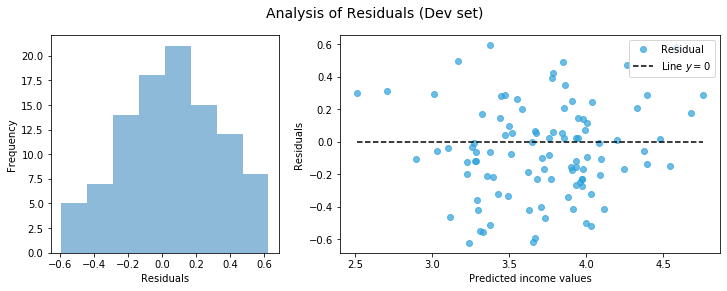

In [11]:
# sort the values of x before line plot
residuals = ydev - y_dev_pred

# plot the histograms of residuals
fig, ax = plt.subplots(1,2, figsize = (12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 5]) 
ax[0] = plt.subplot(gs[0])
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Frequency')
ax[0].hist(residuals, alpha = 0.5, bins=8)

# plot the predictions vs residuals
ax[1] = plt.subplot(gs[1])
ax[1].plot(y_dev_pred, y_dev_pred - ydev,'o',color='#2ea2db',alpha=0.7,label = 'Residual')
ax[1].plot([y_dev_pred.min(),y_dev_pred.max()],[0,0],'k--',label = 'Line $y=0$')
ax[1].set_xlabel('Predicted income values',fontsize=10)
ax[1].set_ylabel('Residuals',fontsize=10)
ax[1].legend(loc='upper right',fontsize=10)
fig.suptitle('Analysis of Residuals (Dev set)',fontsize=14);

Oh, that's good. That's really good! If it didn't look like it were normally distributed (left graph), then it would indicate that our features aren't linearly independent, and that we'd need to carefully remove some. Notwithstanding, it still might be the case that some features aren't too helpful. On the right, we see that there seems very little pattern as to how far off our predictions are. That is, when we make extreme predictions (very low or very high scores), our predictions tend to be inaccurate. When we make average score predictions, our residuals are kind of uniformly spread.

Let's look at the *coefficients*, to gain insights:

In [12]:
coefs = pd.DataFrame(lreg.coef_, columns=['Coefficients'], index=features[1:])
coefs

,Coefficients
Age,0.011533
ABV %,0.020882
Price,0.126616
Rare,-0.060881
Expert Score,0.038997
Smoky,0.002060
Peaty,-0.003457
Spicy,-0.001789
Herbal,-0.001086
Oily,-0.000878


It can be difficult to interpret the meaning of these coefficients because:
- some features have different scales (e.g., the 14 flavors each is from 1-100 but price is from 1-5)
- one feature is categorical (Rare).

It makes sense that the flavors all have low values, and that some are _slightly_ negative. For example, most bourbons have low flavor values for *Herbal*. So, if a bourbon has an Herbal value of 50, this feature alone will contribute a **0.0543 decrease** in the overall prediction of the customer rating. Keep in mind, this rating should be between 0 and 5. Speaking of which, linear regression is entirely capable of making predictions beyond 5, which is an unfortunate artifact. If we print `y_dev_pred.max()` and `y_dev_pred.min()`, we see that all predictions were between 2.72 and 4.88, which is perfectly reasonable!

Regarding the other coefficients, they all seem justifiable to me and nothing has caused concern for me yet. For example, the **Expert Score** is out of 100 and has one of the largest coefficients. As an example, if an Expert Score is 50, it alone will contribute 1.94. But, if it has a score of 100, it'll contribute twice as much (3.8897). Clearly, such a high-rated bourbon ought to receive higher than a 3.7098 from customers, and this is what we rely on the other features to contribute. So, a higher **ABV %**, **Price**, and **Age** all contribute toward a higher score.

The *Rare* feature is possibly just noise. It has a low value (-0.06). So, if a bourbon is denoted as being rare, it only contribute 0.02. Possible explanations are the training/dev data and that the tag itself seems a bit unreliable. Within the EDA, I detailed that several very hard-to-find whiskeys didn't have the rarity tag. Moreover, if a whiskey truly is rare, it can be rare because it's highly desired and in limited supply, or because it's from a very small distillery and produces very basic, low-quality whiskey.

### QUESTION: how do we know if we're suffering from not having enough data?

<div class='exercise'><b>(Baseline model) Simple Multi-linear Regression + Boostrapping</b></div>

Using just 1 run, as we did above, is short-sighted, and we can't place too much stock into the performance or features' coefficients. Let's perform bootstrapping with 100 samples (using 100% of the training data each time), while keeping track of (a) the coefficients so that we can see a distribution of them; and (2) the MSE performance on the dev set.

In [13]:
num_bootstraps = 100
bootstrap_coefs = []
train_MSEs = []
dev_MSEs = []

# bootstrapping will shuffle the rows, so we need to ensure
# that the y's maintain the same order as the x's
merged = pd.concat([xtrain, ytrain], axis=1, sort=False)

for i in range(num_bootstraps):

    boot_df = merged.sample(frac=1, replace=True)

    xtrain_boot = boot_df.drop(["Name", "Customers\' Rating"], axis=1)
    ytrain_boot = boot_df["Customers\' Rating"]
    
    boot_lr = LinearRegression()
    boot_lr.fit(xtrain_boot, ytrain_boot)
    
    # evaluate on the train set
    y_train_pred_boot = boot_lr.predict(xtrain_boot)
    train_MSE_boot = mean_squared_error(ytrain_boot, y_train_pred_boot)
    round(train_MSE_boot, 5)
    train_MSEs.append(train_MSE_boot)

    # evaluate on the dev set
    y_dev_pred_boot = boot_lr.predict(xdev.drop(['Name'], axis=1))
    dev_MSE_boot = mean_squared_error(ydev, y_dev_pred_boot)
    round(dev_MSE_boot, 5)
    dev_MSEs.append(dev_MSE_boot)
    
    bootstrap_coefs.append(boot_lr.coef_)

bootstrap_coefs = np.array(bootstrap_coefs)

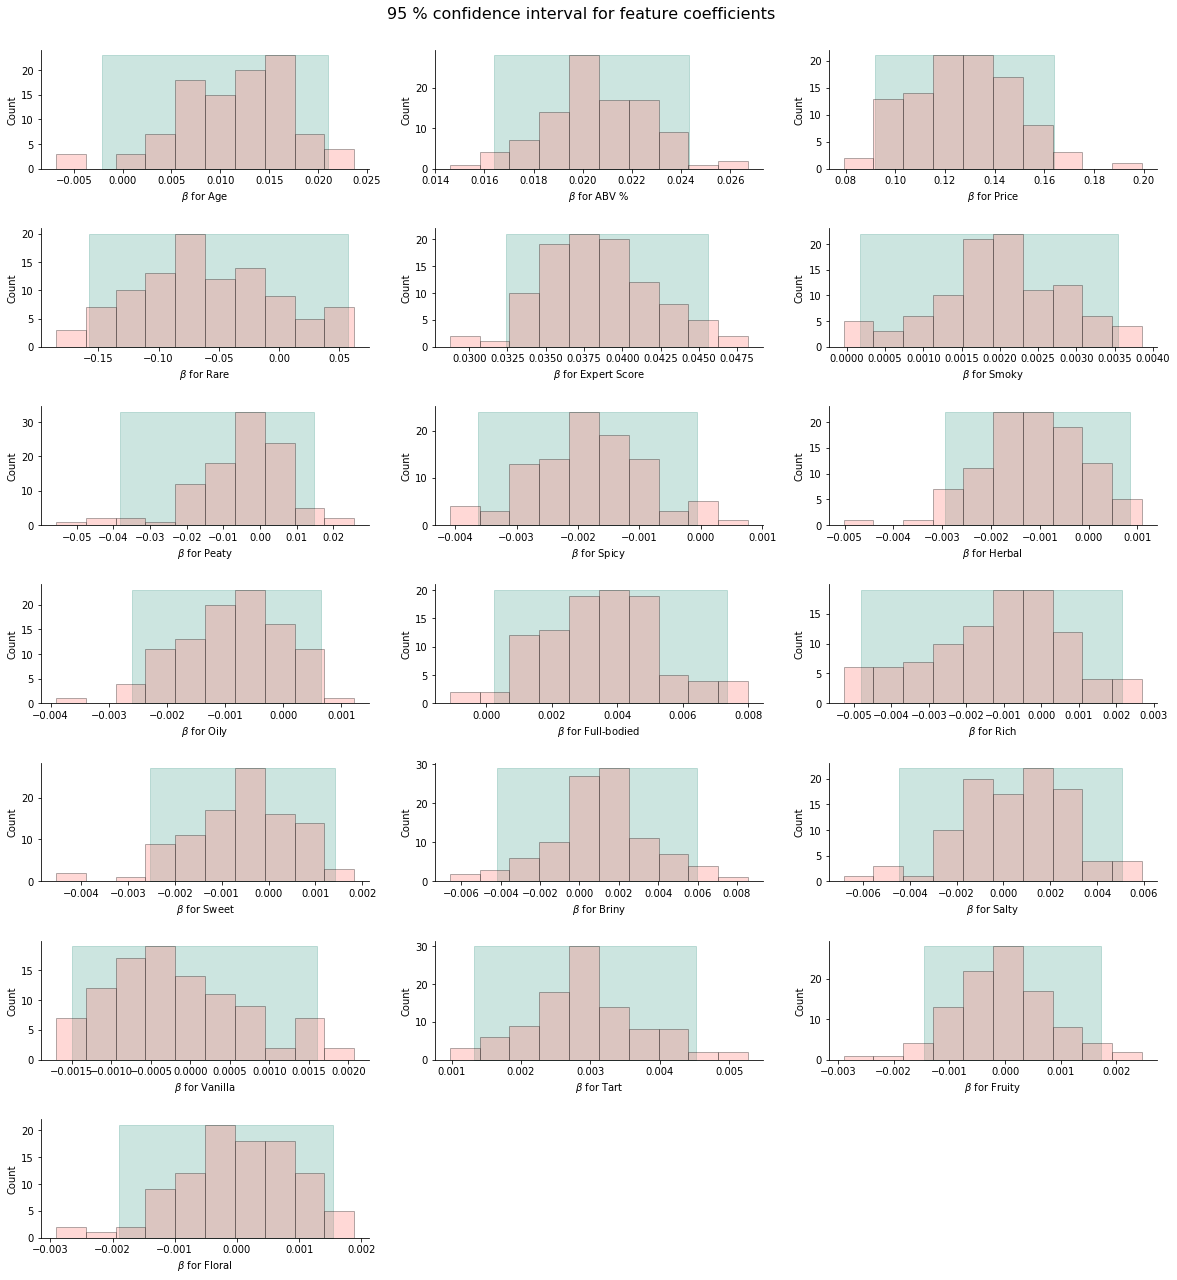

In [14]:
## PLOTS THE HISTOGRAMS OF BETA COEFFICIENTS
fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
ax = ax.ravel()
fontsize = 10

for i in range(1, len(features)):
    
    betavals = bootstrap_coefs[:,i-1]
    betavals.sort()
    
    x1 = np.percentile(betavals,2.5)
    x2 = np.percentile(betavals,97.5)
    x = np.linspace(x1,x2,500)
    counts, bins = np.histogram(betavals)
    y = counts.max()
    
    ax[i-1].hist(bootstrap_coefs[:,i-1],bins=10, color="#FF7E79",alpha=0.3,edgecolor='black', linewidth=1)
    ax[i-1].fill_between(x,y, color = '#007D66',alpha=0.2)
    
    # prettify
    ax[i-1].set_ylabel(f'Count',fontsize=10)
    ax[i-1].set_xlabel(r'$\beta$ for ' + features[i],fontsize=10)

ax[19].set_axis_off()
ax[20].set_axis_off()

plt.xticks(fontsize=20)
fig.suptitle(f'95 % confidence interval for feature coefficients', fontsize=16)
fig.subplots_adjust(top=0.95)
sns.despine()

Hey, this looks pretty good! Each beta coefficient looks pretty normally distributed, and the range of values isn't too large. Part of this narrow range can be explained by the small data size.

To see the variation of the actual predictions, let's plot the MSE that came from each dev split.

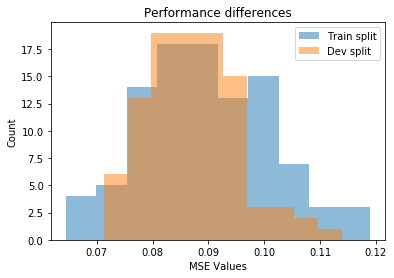

In [15]:
plt.figure(figsize=(6,4))
plt.hist(train_MSEs, bins=10, alpha=0.5, label="Train split")
plt.hist(dev_MSEs, bins=10, alpha=0.5, label="Dev split")

plt.xlabel("MSE Values", size=10)
plt.ylabel("Count", size=10)
plt.title("Performance differences")
plt.legend(loc='upper right')

Ah, shucks, that's completely unexpected. The training accuracy should be better (lower) than the dev accuracy.

### QUESTION: what could be causes?

### ANSWER:

In general, this could mean at least one of several things likely occurred:
- our training and dev splits aren't *too* similar to one another
- our training and/or dev splits are too small
- there isn't enough of a signal to properly learn (e.g., bad features, or too many features)
- we didn't train our model long enough (not applicable for simple linear regression)

Our data is really small (400 training samples). So, let's try cross-validation in addition to bootstrapping!

<div class='exercise'><b>Simple Multi-linear Regression + Bootstrapping + Cross-validation</b></div>

Using just 1 split, as we did above, is short-sighted, and we can't place too much stock into the coefficients and results. So, let's use 10-fold cross-validation for each of 100 bootstrapped samples!

In [16]:
num_bootstraps = 100
bootstrap_coefs = []
# i want things to be random, but consistent for everyone who runs this.
# we need to generate 100 bootstraps, each of which should
# be a random sample of the data. if a single bootstrap
# sample has a `random_state` defined, then the sample will be
# the same every time. well, i want 100 of these unique ones,
# so i generate a list of 100 random seeds. this list of seeds
# needs to be fixed, which is what i do in the following 2 lines:
random.seed(a=21)
bootstrap_seeds = random.sample(range(100000), num_bootstraps)

# now we include all of the original 'train'
# which encompasses the original 'dev' but excludes the 'test'
merged = pd.concat([x_, y_], axis=1, sort=False)

train_MSEs = []
dev_MSEs = []
for i in range(num_bootstraps):
    
    boot_df = merged.sample(frac=1, replace=True, random_state=bootstrap_seeds[i])
    
    kf = KFold(n_splits=10, random_state=270)
    #kf.get_n_splits(boot_df.drop(["Customers\' Rating"], axis=1))
    for train_index, dev_index in kf.split(boot_df):

        xtrain_cv = boot_df.iloc[train_index].drop(["Name", "Customers\' Rating"], axis=1)
        ytrain_cv = boot_df.iloc[train_index]["Customers\' Rating"]
        
        xdev_cv = boot_df.iloc[dev_index].drop(["Name", "Customers\' Rating"], axis=1)
        ydev_cv = boot_df.iloc[dev_index]["Customers\' Rating"]
        
        cv_lr = LinearRegression()
        cv_lr.fit(xtrain_cv, ytrain_cv)
        
        # evaluate on the train set
        y_train_pred_cv = cv_lr.predict(xtrain_cv)
        train_MSE_cv = mean_squared_error(ytrain_cv, y_train_pred_cv)
        round(train_MSE_cv, 5)
        train_MSEs.append(train_MSE_cv)

        # evaluate on the dev set
        y_dev_pred_cv = cv_lr.predict(xdev_cv)
        dev_MSE_cv = mean_squared_error(ydev_cv, y_dev_pred_cv)
        round(dev_MSE_cv, 5)
        dev_MSEs.append(dev_MSE_cv)

        bootstrap_coefs.append(cv_lr.coef_)
    
print("train_MSEs:", np.mean(train_MSEs))
print("dev_MSEs:", np.mean(dev_MSEs))
bootstrap_coefs = np.array(bootstrap_coefs)

train_MSEs: 0.08578783379420153
dev_MSEs: 0.09414415195967932


We now see the property that we'd expect: the dev accuracy is worse than the training accuracy, although only by a little. We could probably benefit from having:
- more data observations (i.e., whiskeys)
- possibly different features
- possibly better modelling

We can't make **more** data observations (whiskeys), and we've done a lot to sample our data so as to make our results more robust and meaningful. So, let's focus on trying **different features**, and then we can move on to other modelling choices!

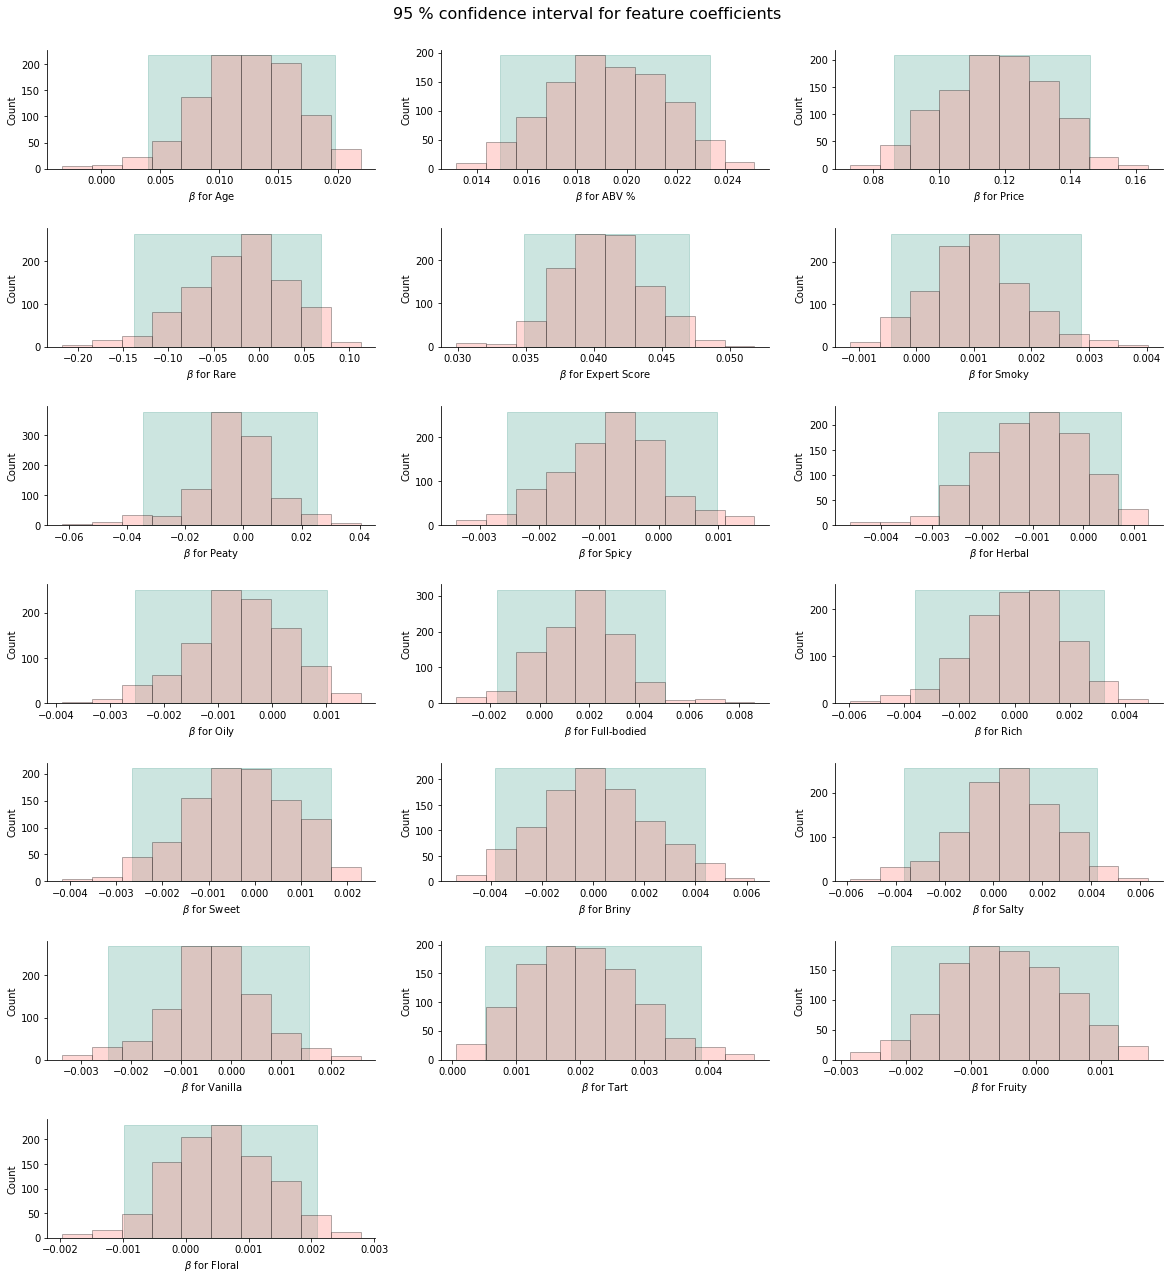

In [17]:
## PLOTS THE HISTOGRAMS OF BETA COEFFICIENTS
fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
ax = ax.ravel()
fontsize = 10

for i in range(1, len(features)):
    
    betavals = bootstrap_coefs[:,i-1]
    betavals.sort()
    
    x1 = np.percentile(betavals,2.5)
    x2 = np.percentile(betavals,97.5)
    x = np.linspace(x1,x2,500)
    counts, bins = np.histogram(betavals)
    y = counts.max()
    
    ax[i-1].hist(bootstrap_coefs[:,i-1],bins=10, color="#FF7E79",alpha=0.3,edgecolor='black', linewidth=1)
    ax[i-1].fill_between(x,y, color = '#007D66',alpha=0.2)
    
    # prettify
    ax[i-1].set_ylabel(f'Count',fontsize=10)
    ax[i-1].set_xlabel(r'$\beta$ for ' + features[i],fontsize=10)

ax[19].set_axis_off()
ax[20].set_axis_off()

plt.xticks(fontsize=20)
fig.suptitle(f'95 % confidence interval for feature coefficients', fontsize=16)
fig.subplots_adjust(top=0.95)
sns.despine()

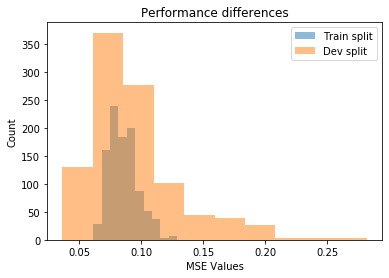

In [18]:
plt.figure(figsize=(6,4))
plt.hist(train_MSEs, bins=10, alpha=0.5, label="Train split")
plt.hist(dev_MSEs, bins=10, alpha=0.5, label="Dev split")

plt.xlabel("MSE Values", size=10)
plt.ylabel("Count", size=10)
plt.title("Performance differences")
plt.legend(loc='upper right')

We see that the coefficients look even more normally distributed, and the MSE values for the training are more reasonable now -- compared to the dev set. The dev set performance has quite a span, which makes sense because we tried *many* splits (1,000 tests), and the data is small.

<div class='exercise'><b>Feature Selection with Simple Multi-linear Regression + Bootstrapping + Cross-validation</b></div>

Above, we threw the entire kitchen sink at the problem (aka, all features). Let's do forward passes to iteratively determine, in a greedy fashion, which combination of features yields the best results, on average. Keep in mind that the data is small, so there will be some noise. Specifically, let's start with just 1 feature (which performs best by itself), then keep adding 1 more feature, while keeping track of the performances.

In [19]:
num_bootstraps = 50
bootstrap_coefs = []

random.seed(a=21)
bootstrap_seeds = random.sample(range(100000), num_bootstraps)

# now we include all of the original 'train'
# which encompasses the original 'dev' but excludes the 'test'
merged = pd.concat([x_, y_], axis=1, sort=False)

selected_features = []
candidate_features = features[1:]
mse_across_features = []

while len(candidate_features) > 0:

    best_mse = 9999
    best_feature = ""

    for i, feature in enumerate(candidate_features):
        
        dev_MSEs = []
        for i in range(num_bootstraps):

            boot_df = merged.sample(frac=1, replace=True, random_state=bootstrap_seeds[i])

            kf = KFold(n_splits=10, random_state=270)
            #kf.get_n_splits(boot_df.drop(["Customers\' Rating"], axis=1))
            for train_index, dev_index in kf.split(boot_df):

                xtrain_cv = boot_df.iloc[train_index][selected_features + [feature]]
                ytrain_cv = boot_df.iloc[train_index]["Customers\' Rating"]

                xdev_cv = boot_df.iloc[dev_index][selected_features + [feature]]
                ydev_cv = boot_df.iloc[dev_index]["Customers\' Rating"]

                cv_lr = LinearRegression()
                cv_lr.fit(xtrain_cv, ytrain_cv)

                # evaluate on the dev set
                y_dev_pred_cv = cv_lr.predict(xdev_cv)
                dev_MSE_cv = mean_squared_error(ydev_cv, y_dev_pred_cv)
                round(dev_MSE_cv, 5)
                dev_MSEs.append(dev_MSE_cv)

        cur_mse = np.mean(dev_MSEs)
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_feature = feature

    mse_across_features.append(best_mse)
    print("best feature:", best_feature)
    selected_features.append(best_feature)
    candidate_features.remove(best_feature)

best feature: Expert Score
best feature: Price
best feature: ABV %
best feature: Age
best feature: Tart
best feature: Herbal
best feature: Smoky
best feature: Full-bodied
best feature: Spicy
best feature: Fruity
best feature: Vanilla
best feature: Sweet
best feature: Rich
best feature: Floral
best feature: Oily
best feature: Salty
best feature: Briny
best feature: Peaty
best feature: Rare


Let's plot the performance as we increased the # of features.

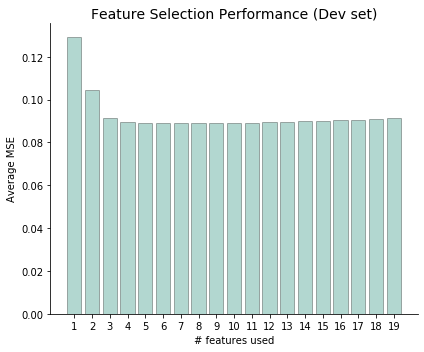

In [20]:
ind = [_ + 1 for _ in range(len(features)-1)]

fig, ax = plt.subplots(figsize=(6,5))
ax.bar(ind, mse_across_features, color = '#007D66',alpha=0.3,edgecolor='k')
ax.set_xticks(sorted(ind));
ax.set_xlabel(r'# features used', fontsize=10)
ax.set_ylabel('Average MSE', fontsize=10)
ax.set_title(f'Feature Selection Performance (Dev set)',fontsize=14)
sns.despine()
plt.tight_layout()

In [21]:
best_num_features = np.argmin(mse_across_features)
print("best_num_features:", best_num_features)
print("features:", selected_features[0:best_num_features])
print("mse_across_features:", np.min(mse_across_features))

best_num_features: 6
features: ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart', 'Herbal']
mse_across_features: 0.08898992695054489


The results plateau, and adding more features doesn't offer any significant change.

In [22]:
for i in range(len(selected_features)):
    print(mse_across_features[i], selected_features[0:i])

0.12909522321420297 []
0.1044492865665544 ['Expert Score']
0.09129133372424443 ['Expert Score', 'Price']
0.08965466716306167 ['Expert Score', 'Price', 'ABV %']
0.08923430250733025 ['Expert Score', 'Price', 'ABV %', 'Age']
0.08899175542814948 ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart']
0.08898992695054489 ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart', 'Herbal']
0.08907203953495638 ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart', 'Herbal', 'Smoky']
0.08904955558657023 ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart', 'Herbal', 'Smoky', 'Full-bodied']
0.08912186240983001 ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart', 'Herbal', 'Smoky', 'Full-bodied', 'Spicy']
0.08922281913220305 ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart', 'Herbal', 'Smoky', 'Full-bodied', 'Spicy', 'Fruity']
0.08939031344729367 ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart', 'Herbal', 'Smoky', 'Full-bodied', 'Spicy', 'Fruity', 'Vanilla']
0.0895770795888184 ['Expert Score', 'Price', 'ABV %', 'Age', 'Tar

An MSE of 0.09 seems pretty good to me! Let's compare it to other models.

## 3. kNN

Let's start simple, as we did with Linear Regression. We begin by fitting a kNN regressor on 1 particular split (the original one). The purpose of starting small is to ensure we're doing it correctly and that the results make sense.

In [33]:
# create and fit a kNN regressor
k = 5
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(xtrain.drop(['Name'], axis=1), ytrain)

# evaluate on the training set
y_train_pred = knn_model.predict(xtrain.drop(['Name'], axis=1))
mse_train = mean_squared_error(ytrain, y_train_pred)

# evaluate on the dev set
y_dev_pred = knn_model.predict(xdev.drop(['Name'], axis=1))
mse_dev = mean_squared_error(ydev, y_dev_pred)
mse_dev

print("mse_train:", mse_train, "mse_dev:", mse_dev)

mse_train: 0.14111582000000003 mse_dev: 0.1996808


Ok, it runs! However, those scores look much worse than what we started with when using linear regression. Hmm, hopefully it can improve. Let's vary our **k** value and see if we can do better for this original data split.

In [34]:
max_k = 20
train_MSEs = []
dev_MSEs = []

for k in range(1, max_k):

    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(xtrain.drop(['Name'], axis=1), ytrain)

    # evaluate on the training set
    y_train_pred = knn_model.predict(xtrain.drop(['Name'], axis=1))
    train_MSE = round(mean_squared_error(ytrain, y_train_pred), 5)
    train_MSEs.append(train_MSE)
    
    # evaluate on the dev set
    y_dev_pred = knn_model.predict(xdev.drop(['Name'], axis=1))
    dev_MSE = round(mean_squared_error(ydev, y_dev_pred), 5)
    dev_MSEs.append(dev_MSE)
    
    print("k:", k, "train_MSE:", train_MSE, "dev_MSE:", dev_MSE)
print("*** best result was k =", np.argmin(dev_MSEs), ":", np.min(dev_MSEs))

k: 1 train_MSE: 0.00012 dev_MSE: 0.28597
k: 2 train_MSE: 0.08047 dev_MSE: 0.23643
k: 3 train_MSE: 0.11501 dev_MSE: 0.22813
k: 4 train_MSE: 0.13051 dev_MSE: 0.21735
k: 5 train_MSE: 0.14112 dev_MSE: 0.19968
k: 6 train_MSE: 0.14608 dev_MSE: 0.19611
k: 7 train_MSE: 0.15572 dev_MSE: 0.19327
k: 8 train_MSE: 0.16047 dev_MSE: 0.189
k: 9 train_MSE: 0.16409 dev_MSE: 0.19695
k: 10 train_MSE: 0.16373 dev_MSE: 0.19697
k: 11 train_MSE: 0.16789 dev_MSE: 0.19521
k: 12 train_MSE: 0.17082 dev_MSE: 0.19363
k: 13 train_MSE: 0.17434 dev_MSE: 0.19383
k: 14 train_MSE: 0.17493 dev_MSE: 0.19486
k: 15 train_MSE: 0.17601 dev_MSE: 0.19033
k: 16 train_MSE: 0.17767 dev_MSE: 0.18629
k: 17 train_MSE: 0.17972 dev_MSE: 0.18922
k: 18 train_MSE: 0.18203 dev_MSE: 0.18567
k: 19 train_MSE: 0.18227 dev_MSE: 0.18446
*** best result was k = 18 : 0.18446


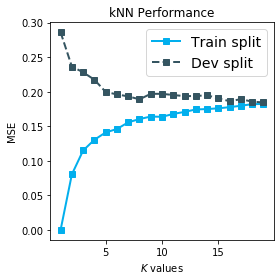

In [35]:
# let's visualize the trend
ind = [_ + 1 for _ in range(max_k-1)]
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(ind, train_MSEs, 's-', label='Train split',color='#02afed',linewidth=2)
ax.plot(ind, dev_MSEs, 's--', label='Dev split',color='#355561',linewidth=2)
ax.set_xlabel(r'$K$ values', fontsize=10)
ax.set_ylabel('MSE', fontsize=10)
ax.set_title(r'kNN Performance')
ax.legend(fontsize=14)
fig.tight_layout()

Ah, that's not as good as linear regression! This is only over 1 split. Let's do the same procedure we did with linear regression, so that it's a fair comparison: feature selection + boostrapping + cross-validation. 

In [26]:
best_num_features = np.argmin(mse_across_features)
print("best_num_features:", best_num_features)
print("features:", selected_features[0:best_num_features])
print("mse_across_features:", np.min(mse_across_features))

best_num_features: 6
features: ['Expert Score', 'Price', 'ABV %', 'Age', 'Tart', 'Herbal']
mse_across_features: 0.08898992695054489


In [27]:
min_k = 12
max_k = 18

num_bootstraps = 10
bootstrap_coefs = []

random.seed(a=21)
bootstrap_seeds = random.sample(range(100000), num_bootstraps)

# now we include all of the original 'train'
# which encompasses the original 'dev' but excludes the 'test'
merged = pd.concat([x_, y_], axis=1, sort=False)

k_to_num_features = {}
k_to_best_features = {}
for k in range(min_k, max_k):
    selected_features = []
    candidate_features = features[1:]
    mse_across_features = []

    while len(candidate_features) > 0:

        best_mse = 9999
        best_feature = ""

        for i, feature in enumerate(candidate_features):

            dev_MSEs = []
            for i in range(num_bootstraps):

                boot_df = merged.sample(frac=1, replace=True, random_state=bootstrap_seeds[i])

                kf = KFold(n_splits=10, random_state=270)
                for train_index, dev_index in kf.split(boot_df):

                    xtrain_cv = boot_df.iloc[train_index][selected_features + [feature]]
                    ytrain_cv = boot_df.iloc[train_index]["Customers\' Rating"]

                    xdev_cv = boot_df.iloc[dev_index][selected_features + [feature]]
                    ydev_cv = boot_df.iloc[dev_index]["Customers\' Rating"]

                    knn_model = KNeighborsRegressor(n_neighbors=k)
                    knn_model.fit(xtrain_cv, ytrain_cv)

                    # evaluate on the training set
                    y_train_pred = knn_model.predict(xtrain_cv)
                    train_MSE = round(mean_squared_error(ytrain_cv, y_train_pred), 5)
                    train_MSEs.append(train_MSE)

                    # evaluate on the dev set
                    y_dev_pred = knn_model.predict(xdev_cv)
                    dev_MSE = round(mean_squared_error(ydev_cv, y_dev_pred), 5)
                    dev_MSEs.append(dev_MSE)

            cur_mse = np.mean(dev_MSEs)
            if cur_mse < best_mse:
                best_mse = cur_mse
                best_feature = feature

        mse_across_features.append(np.min(best_mse))
        selected_features.append(best_feature)
        candidate_features.remove(best_feature)
        
    print("k:", k, "best_mse:", best_mse)
    k_to_num_features[k] = mse_across_features
    k_to_best_features[k] = selected_features[0:np.argmin(mse_across_features)+1]

k: 12 best_mse: 0.1869475999999999
k: 13 best_mse: 0.18727519999999998
k: 14 best_mse: 0.1882234
k: 15 best_mse: 0.1890631
k: 16 best_mse: 0.18984310000000001
k: 17 best_mse: 0.1905571


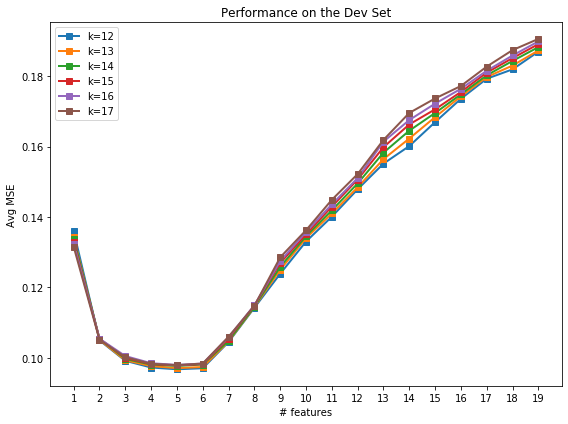

In [28]:
# let's visualize the trend
ind = [_ + 1 for _ in range(len(features)-1)]
fig, ax = plt.subplots(1,1, figsize=(8,6))
len(k_to_num_features[12])
for k in range(min_k, max_k):
    ax.plot(ind, k_to_num_features[k], 's-', label='k='+str(k),linewidth=2)

ax.set_xlabel(r'# features', fontsize=10)
ax.set_ylabel('Avg MSE', fontsize=10)
ax.set_title(r'Performance on the Dev Set')
ax.legend(fontsize=10)
xint = range(min(ind), math.ceil(max(ind))+1)
matplotlib.pyplot.xticks(xint)
fig.tight_layout()

In [29]:
k_to_num_features

{12: [0.13591640000000002,
  0.10494430000000002,
  0.09913929999999997,
  0.09723290000000001,
  0.09672829999999999,
  0.09702670000000001,
  0.10447569999999999,
  0.11420819999999997,
  0.12387369999999999,
  0.1330116,
  0.1400715,
  0.14785450000000003,
  0.15514190000000003,
  0.1601279,
  0.1669202,
  0.17356739999999998,
  0.1792516,
  0.1819095,
  0.1869475999999999],
 13: [0.1343208,
  0.10509180000000003,
  0.09929230000000003,
  0.09763709999999999,
  0.097058,
  0.09737620000000001,
  0.10464460000000003,
  0.11440120000000001,
  0.12499389999999998,
  0.13398030000000002,
  0.1409857,
  0.1484114,
  0.1564101,
  0.16226759999999998,
  0.16834949999999996,
  0.17425569999999996,
  0.17974549999999997,
  0.1829839,
  0.18727519999999998],
 14: [0.13382,
  0.10542790000000002,
  0.09966219999999999,
  0.09805530000000001,
  0.09768320000000003,
  0.09808360000000002,
  0.10480590000000004,
  0.1145414,
  0.1258255,
  0.13452319999999998,
  0.1418784,
  0.1495025,
  0.158253

In [30]:
best_k = 0
best_mse = 99999

for k in k_to_num_features.keys():
    cur_num_features = np.argmin(k_to_num_features[k]) + 1
    cur_best_mse = np.min(k_to_num_features[k])
    if cur_best_mse < best_mse:
        best_mse = cur_best_mse
        best_k = k
    
print("best_k:", best_k, "best_mse:", best_mse)
print("best features:", k_to_best_features[best_k])

best_k: 12 best_mse: 0.09672829999999999
best features: ['Expert Score', 'ABV %', 'Price', 'Age', 'Rare']


### QUESTION:

The MSE when using kNN seems to come close to Linear Regression. Is there anything we could/should change about this kNN experiment?


### ANSWER:

Scale our data! The features aren't on the same scale, so the distant metric used by kNN (e.g., Euclidean distance) doesn't account for this. The most useful features still include most of what we saw from Linear Regression, so this indicates that our lack of scaling is not a big problem, but it's definitely the proper thing to do. I'm surprised `Price` and `Rare` were able to make it into our list of top features, since their scales are just way smaller than the others that are from 0-100.